In [ ]:
##! SKIP THIS if on Google Colaboratory
%load_ext notexbook
%texify

# Fast Gradient Sign Attack

This notebook showcases how to carry out a **Fast Gradient Sign Attack** (`FGSA`) to a pretrained model. 

**Note** This notebook has been adapted from the [FSGM Tutorial](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html) by _Nathan Inkawhich_ `@inkawhich` available on the official [PyTorch Documentation](https://pytorch.org/docs/stable/index.html)

(_from the original notebook_)
> This tutorial will raise your awareness to the security vulnerabilities 
> of ML models, and will give insight into the hot topic of adversarial machine learning. 
> 
> You may be surprised to find that adding **imperceptible perturbations** to an image *can* cause 
> drastically different model performance.
> `[...]`
>
> Specifically we will use one of the first and most popular attack methods, the _Fast Gradient Sign Attack_
> (`FGSM`), to fool an `MNIST` classifier.


## Threats to Models

There are several kinds of assumptions of the attacker’s knowledge, two of which are: **white-box** and **black-box**. 

- A *white-box* attack assumes the attacker has full knowledge and access to the model, including
architecture, inputs, outputs, and weights. 
- A *black-box* attack assumes the attacker only has access to the inputs and outputs of the model, and knows nothing about the underlying architecture or weights. 

There are also several types of goals, including **misclassification** and
**source/target misclassification**. 

A goal of *misclassification* means the adversary only wants the output classification to be wrong but does
not care what the new classification is. 

A *source/target misclassification* means the adversary wants to alter an image that is originally of a specific source class so that it is classified as a specific target class.

## Fast Gradient Sign Attack

*Fast Gradient Sign Attack (FGSM)* and is described by _Goodfellow et. al._ in 
[Explaining and Harnessing Adversarial Examples](https://arxiv.org/abs/1412.6572). 

The attack is remarkably powerful, and yet intuitive. 

It is designed to attack neural networks by leveraging the way they learn: **gradients**. 

The idea is simple: 

> rather than working to minimize the loss by adjusting the weights based on the backpropagated gradients,
> the attack **adjusts** the input data to maximize the loss based on the same backpropagated gradients. 

In other words, the attack uses the gradient of the loss w.r.t the input data, then adjusts the input data to maximize the loss.

_(from the original paper)_

![fgsm panda attack](https://pytorch.org/tutorials/_images/fgsm_panda_image.png)

**TLDR;** Just perturbe the input data with some small change that would work in an **adversary** fashion (wrt. the optimisation process) that follows the **direction of the gradient** (i.e. $sign(\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y))$ )

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# NOTE: This is a hack to get around "User-agent" limitations when downloading MNIST datasets
#       see, https://github.com/pytorch/vision/issues/3497 for more information
from six.moves import urllib

opener = urllib.request.build_opener()
opener.addheaders = [("User-agent", "Mozilla/5.0")]
urllib.request.install_opener(opener)

In [2]:
from pathlib import Path
import os 

DATA_FOLDER = Path(os.path.join(os.path.abspath(os.path.curdir), "..")) / "data"

In [3]:
print(DATA_FOLDER)

/Users/leriomaggio/Code/Python/Anaconda/ml_ai_program/tutorials/scipy_2023/ppml-tutorial/3-ml-models-attacks/../data


In [5]:
# Reproducibility Settings

import numpy as np

SEED = 123456
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

#### `LeNet` Model

In [6]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

Initialise pre-trained model (and move it to available device)

In [7]:
if torch.cuda.is_available():
    dev_name = "cuda"
elif torch.backends.mps.is_available():
    dev_name = "mps"
else:
    dev_name = "cpu"

device = torch.device(dev_name)
print(f"You will be using the {device} device")

You will be using the mps device


In [8]:
torch.__version__

'2.0.1'

In [9]:
# Uncomment this when running on Anaconda Notebooks
# !wget !wget https://raw.githubusercontent.com/leriomaggio/ppml-tutorial/main/3-ml-models-attacks/lenet_mnist_model.pth

In [10]:
PRETRAINED_MODEL_WEIGHTS = "lenet_mnist_model.pth"

# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(PRETRAINED_MODEL_WEIGHTS, map_location=device))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

### Download MNIST Dataset

In [11]:
# MNIST Test dataset and dataloader declaration
mnist_test = datasets.MNIST(root=DATA_FOLDER, train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=1, shuffle=False)

### Before the Attack

Before carrying out the attack, let's see how well the model classify the digits in the test set

In [12]:
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

y_preds, y_true = list(), list()
with torch.no_grad():  # extra, as model is eval mode anyway
    for (image, target) in tqdm(test_loader):
        image, target = image.to(device), target.to(device)
        out = model(image)
        _, preds = torch.max(out, 1)
        y_preds.append(preds.detach().cpu().numpy())
        y_true.append(target.detach().cpu().numpy())
    y_preds = np.hstack(y_preds)
    y_true = np.hstack(y_true)
    
    print(f"Pre-Trained Model ACC: {accuracy_score(y_true, y_preds)}")

  0%|          | 0/10000 [00:00<?, ?it/s]

Pre-Trained Model ACC: 0.981


### `FSGM` Attack

Now, we can define the function that creates the adversarial examples by
perturbing the original inputs. 

In [13]:
# FGSM attack code
def fgsm_attack(image: torch.Tensor, epsilon: float, data_gradient: torch.Tensor) -> torch.Tensor:
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_gradient.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + (epsilon * sign_data_grad)
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)  # normalise in [0, 1] to make it an actual image
    # Return the perturbed image
    return perturbed_image

Last but not least: the **test function**

In [14]:
def test(model, device, loader, epsilon):
    # from https://github.com/pytorch/tutorials/blob/master/beginner_source/fgsm_tutorial.py
    
    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in tqdm(test_loader, desc=f"Running Attack on Batches with ε={ε}"):

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability

        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))

    # Calculate final accuracy for this epsilon
    final_acc = correct / float(len(test_loader))
    print(
        "Epsilon: {}\tTest Accuracy = {} / {} = {}".format(
            epsilon, correct, len(test_loader), final_acc
        )
    )

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

### Run the Attack

In [15]:
ε = 0.05

In [16]:
acc, adv_examples = test(model, device, test_loader, ε)

Running Attack on Batches with ε=0.05:   0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.05	Test Accuracy = 9426 / 10000 = 0.9426


Now let's see how the perturbed images look like: 

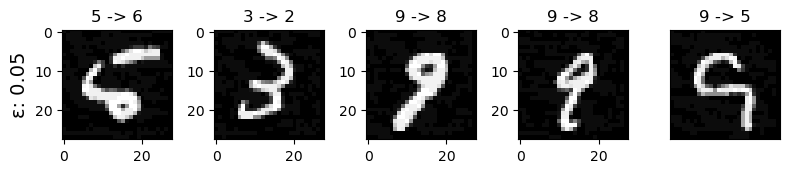

In [17]:
fig, axes = plt.subplots(1, len(adv_examples), figsize=(8, 10))
plt.xticks([], [])
plt.yticks([], [])
for j, (orig_pred, adv_pred, adv_example) in enumerate(adv_examples):
    if j == 0:
        axes[j].set_ylabel(f"ε: {ε}", fontsize=14)
    axes[j].set_title("{} -> {}".format(orig_pred, adv_pred))
    axes[j].imshow(adv_example, cmap="gray")
plt.tight_layout()
plt.show()

### Exercise:

Now the question is: how much degradation in performance we have as soon as we keep incrementing the value of ε?

What we should expect: 
- the bigger ε, the worse the accuracy
- the bigger ε, the more "discoverable" the perturbation becomes
    - so that it's evident that an attack has been launched

In [18]:
EPSILONS = [0.05, .06, .1, .15, .2, .25, .3]

accuracies = [acc]
adv_examples_map = {0.05: adv_examples}

# Run test for each epsilon
for ε in EPSILONS[1:]:
    acc, adv_examples = test(model, device, test_loader, ε)
    accuracies.append(acc)
    adv_examples_map[ε] = adv_examples

Running Attack on Batches with ε=0.06:   0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.06	Test Accuracy = 9280 / 10000 = 0.928


Running Attack on Batches with ε=0.1:   0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.1	Test Accuracy = 8510 / 10000 = 0.851


Running Attack on Batches with ε=0.15:   0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.15	Test Accuracy = 6826 / 10000 = 0.6826


Running Attack on Batches with ε=0.2:   0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.2	Test Accuracy = 4301 / 10000 = 0.4301


Running Attack on Batches with ε=0.25:   0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.25	Test Accuracy = 2082 / 10000 = 0.2082


Running Attack on Batches with ε=0.3:   0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.3	Test Accuracy = 869 / 10000 = 0.0869


### Results

1. Let's print the accuracy values for each corresponding ε value

In [19]:
accuracies

[0.9426, 0.928, 0.851, 0.6826, 0.4301, 0.2082, 0.0869]

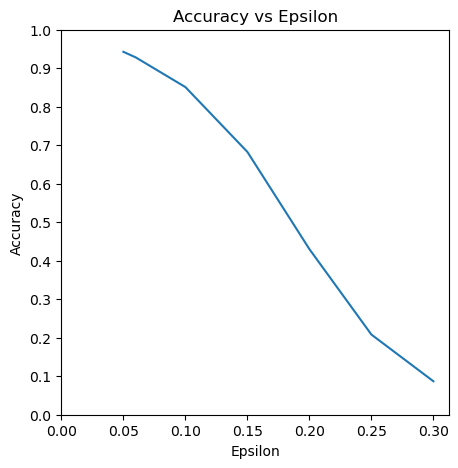

In [20]:
plt.figure(figsize=(5, 5))

# your code here: plot Accuracies vs EPSILONS
plt.plot(EPSILONS, accuracies)
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 0.35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

2. Visualise Generated Adversarial Examples

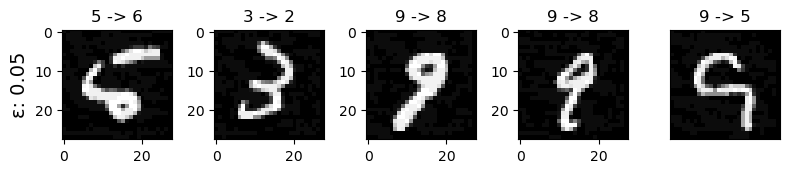

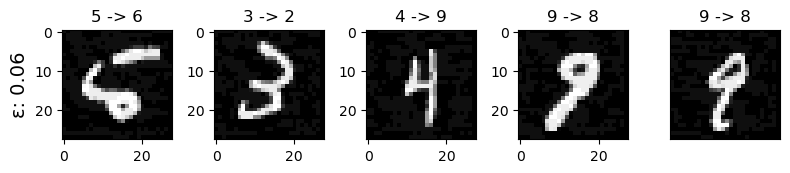

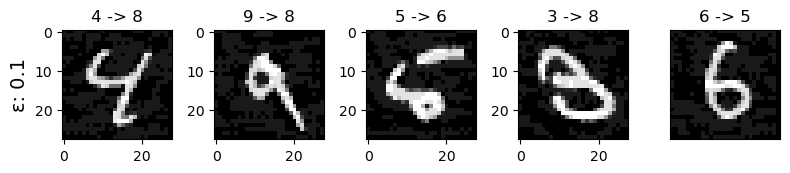

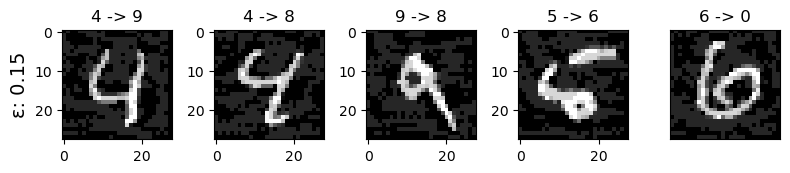

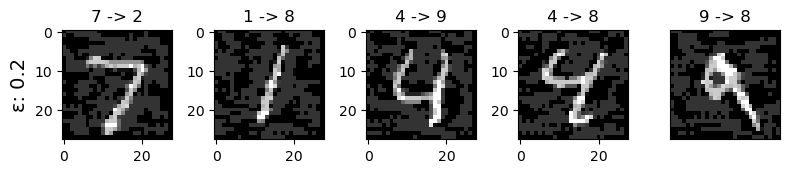

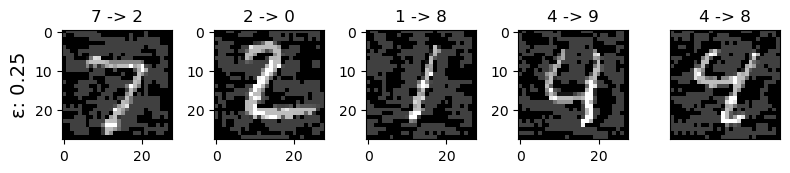

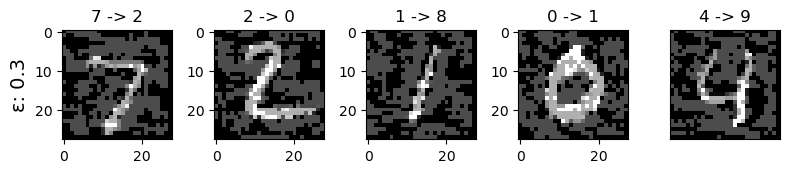

In [21]:
# Plot several examples of adversarial samples at each epsilon

for ε in EPSILONS:
    fig, axes = plt.subplots(1, len(adv_examples_map[ε]), figsize=(8, 10))
    plt.xticks([], [])
    plt.yticks([], [])
    for j, (orig_pred, adv_pred, adv_example) in enumerate(adv_examples_map[ε]):
        if j == 0:
            axes[j].set_ylabel(f"ε: {ε}", fontsize=14)
        axes[j].set_title("{} -> {}".format(orig_pred, adv_pred))
        axes[j].imshow(adv_example, cmap="gray")
    plt.tight_layout()
    plt.show()